In [1]:
from prophet import Prophet
import pandas as pd
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import multiprocessing
multiprocessing.set_start_method("fork")

## Sub-daily data

Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the `ds` column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS - see the example csv [here](https://github.com/facebook/prophet/blob/main/examples/example_yosemite_temps.csv). When sub-daily data are used, daily seasonality will automatically be fit. Here we fit Prophet to data with 5-minute resolution (daily temperatures at Yosemite):

Initial log joint probability = -1444.46
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31654.5     0.0931026       9792.98           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       32103.1     0.0378754       1020.93           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       32236.4    0.00680078       647.363           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       32350.4   0.000300136       910.455   4.391e-07       0.001      472  LS failed, Hessian reset 
     399       32401.2     0.0182259       1960.09           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       32439.1   1.18441e-05    

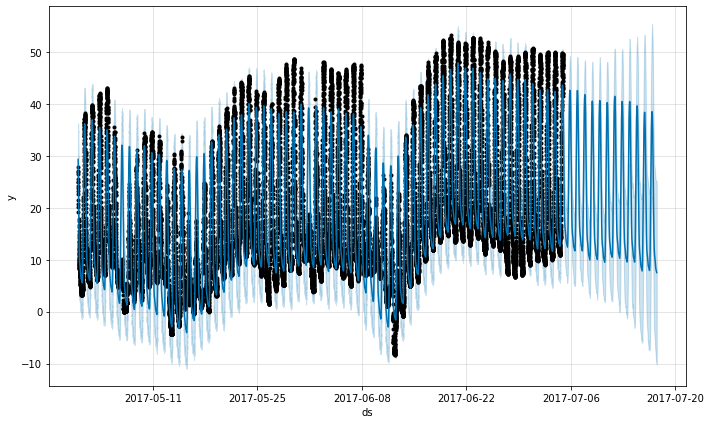

In [3]:
df = pd.read_csv('../examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

The daily seasonality will show up in the components plot:

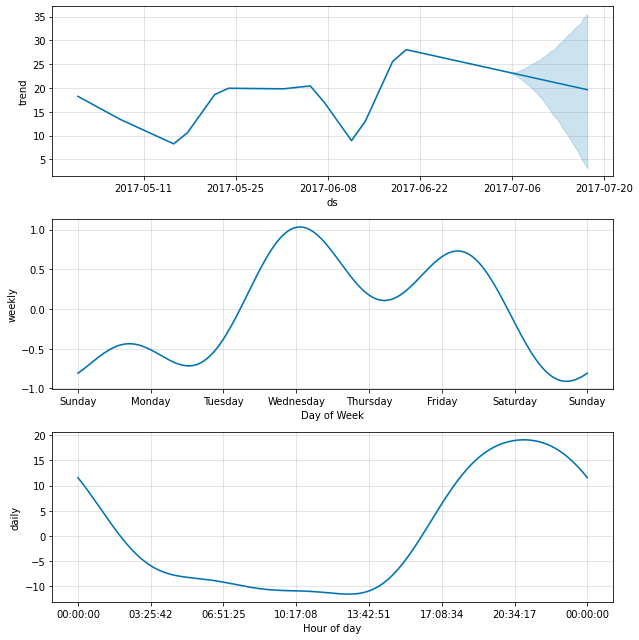

In [4]:
fig = m.plot_components(fcst)

## Data with regular gaps

Suppose the dataset above only had observations from 12a to 6a:

Initial log joint probability = -467.044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8442.7     0.0239385       464.577           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8752.13     0.0119884       921.719      0.7932      0.7932      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8880.17    0.00392451       647.457           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8939.15    0.00505784       706.847      0.3102           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       8952.07   0.000120141       136.344    3.46e-07       0.001      571  LS failed, Hessian reset 
     499        8953.6    0.00372845    

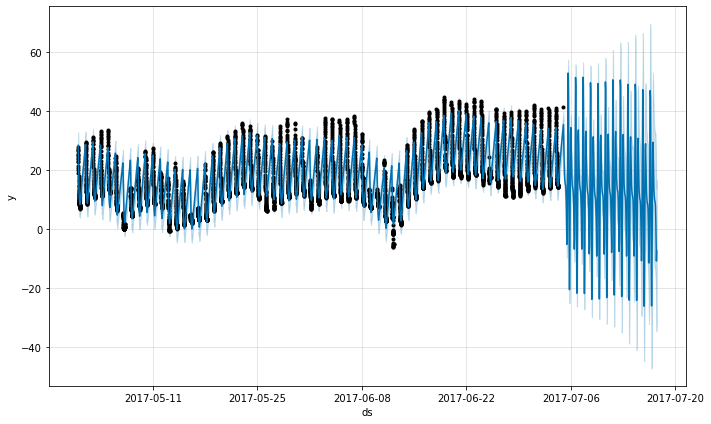

In [5]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

The forecast seems quite poor, with much larger fluctuations in the future than were seen in the history. The issue here is that we have fit a daily cycle to a time series that only has data for part of the day (12a to 6a). The daily seasonality is thus unconstrained for the remainder of the day and is not estimated well. The solution is to only make predictions for the time windows for which there are historical data. Here, that means to limit the `future` dataframe to have times from 12a to 6a:

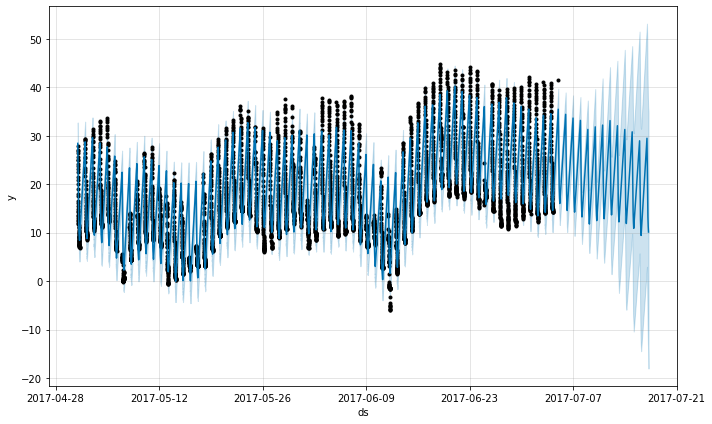

In [6]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

The same principle applies to other datasets with regular gaps in the data. For example, if the history contains only weekdays, then predictions should only be made for weekdays since the weekly seasonality will not be well estimated for the weekends.

## Monthly data

You can use Prophet to fit monthly data. However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. Here we forecast US retail sales volume for the next 10 years:

Initial log joint probability = -2.41173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1022.63    0.00282041       536.092      0.9168      0.9168      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1045.23    0.00333206       105.354           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283          1050   6.11375e-05       106.693    2.16e-07       0.001      367  LS failed, Hessian reset 
     299       1050.48    0.00593573       157.773           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       1058.25   5.52726e-05       158.313   2.533e-07       0.001      525  LS failed, Hessian reset 
     399       1061.91    0.00137873       123.783      0.1634      0.1634      548   
    Iter      log pro

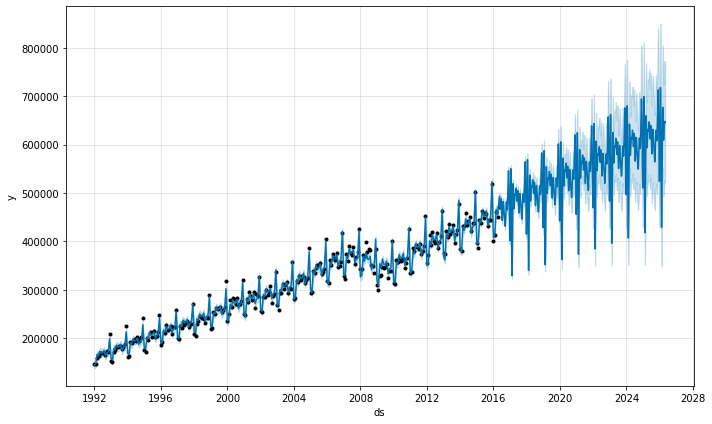

In [7]:
df = pd.read_csv('../examples/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

This is the same issue from above where the dataset has regular gaps. When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. This can be clearly seen by doing MCMC to see uncertainty in the seasonality:


Gradient evaluation took 0.000512 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.12 seconds.

Adjust your expectations accordingly!


Gradient evaluation took 0.000471 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000465 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000479 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.79 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)


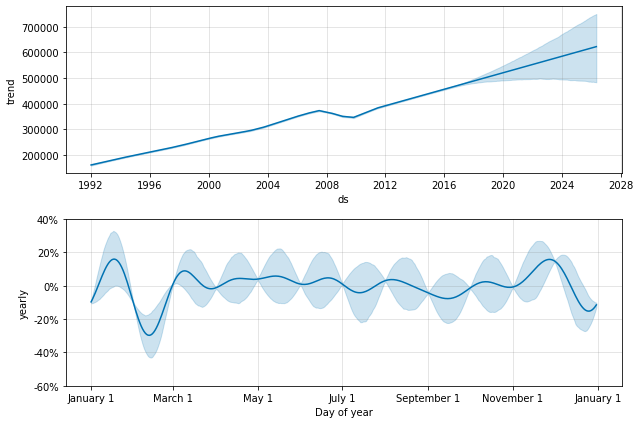

In [8]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
fig = m.plot_components(fcst)

The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into `make_future_dataframe`:

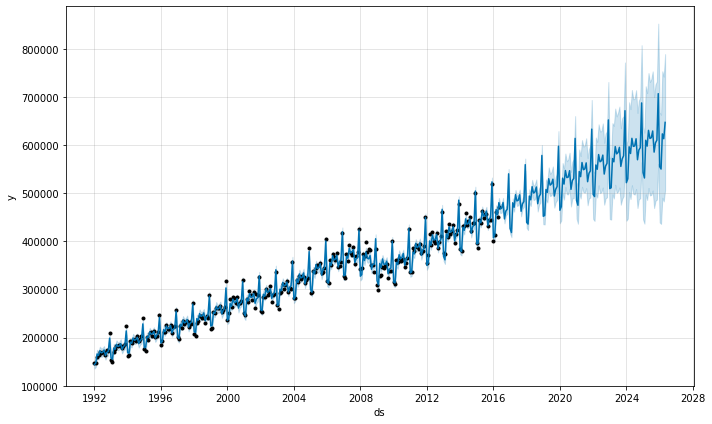

In [9]:
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In Python, the frequency can be anything from the pandas list of frequency strings here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases . Note that `MS` used here is month-start, meaning the data point is placed on the start of each month.

In monthly data, yearly seasonality can also be modeled with binary extra regressors. In particular, the model can use 12 extra regressors like `is_jan`, `is_feb`, etc. where `is_jan` is 1 if the date is in Jan and 0 otherwise. This approach would avoid the within-month unidentifiability seen above. Be sure to use `yearly_seasonality=False` if monthly extra regressors are being added.

## Holidays with aggregated data

Holiday effects are applied to the particular date on which the holiday was specified. With data that has been aggregated to weekly or monthly frequency, holidays that don't fall on the particular date used in the data will be ignored: for example, a Monday holiday in a weekly time series where each data point is on a Sunday. To include holiday effects in the model, the holiday will need to be moved to the date in the history dataframe for which the effect is desired. Note that with weekly or monthly aggregated data, many holiday effects will be well-captured by the yearly seasonality, so added holidays may only be necessary for holidays that occur in different weeks throughout the time series.